In [ ]:
# !pip install --upgrade tensorflow==2.2.0

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import tensorflow.keras.callbacks as cbks
from tensorflow.keras.models import load_model
import os

import warnings
warnings.filterwarnings("ignore")

# Configuration options
feature_vector_length = 2
num_classes = 1
%load_ext tensorboard

## 1. Feature Engineering

In [2]:
data = pd.read_csv("data.csv")

data['label'] = data['label'].astype('int32')

data['2f1'] = data['f1'] * 2
data['f1^2'] = data['f1'] ** 2
data['sqrt_f1'] = np.sqrt(data['f1'])
data['log_f1'] = np.log(data['f1'])
data['exp_f1'] = np.exp(data['f1'])
data['sin_f1'] = np.sin(data['f1'])
data['tan_f1'] = np.tan(data['f1'])

data['2f2'] = data['f2'] * 2
data['f2^2'] = data['f2'] ** 2
data['sqrt_f2'] = np.sqrt(data['f2'])
data['log_f2'] = np.log(data['f2'])
data['exp_f2'] = np.exp(data['f2'])
data['sin_f2'] = np.sin(data['f2'])
data['tan_f2'] = np.tan(data['f2'])

data['f1f2'] = data['f1'] * data['f2']
data['2_f1f2'] = data['2f1'] * data['2f2']
data['sqrt_f1f2'] = data['sqrt_f1'] * data['sqrt_f2']
data['2_log_f1f2'] = data['log_f1'] * data['log_f2']
data['2_f1^2'] = data['f1^2'] * data['f2^2']
data['tan_f1f2'] = data['tan_f1'] * data['tan_f2']
data['sin_f1f2'] = data['sin_f1'] * data['sin_f2']
data['exp_f1f2'] = data['exp_f1'] * data['exp_f2']

data.fillna(0, inplace=True)

data.head()

,f1,f2,label,2f1,f1^2,sqrt_f1,log_f1,exp_f1,sin_f1,tan_f1,2f2,f2^2,sqrt_f2,log_f2,exp_f2,sin_f2,tan_f2,f1f2,2_f1f2,sqrt_f1f2,2_log_f1f2,2_f1^2,tan_f1f2,sin_f1f2,exp_f1f2
0,0.450564,1.074305,0,0.901127,0.203008,0.671240,-0.797256,1.569196,0.435473,0.483750,2.148610,1.154131,1.036487,0.071674,2.927957,0.879259,1.845851,0.484043,1.936171,0.695732,-0.057142,0.234297,0.892931,0.382894,4.594539
1,0.085632,0.967682,0,0.171263,0.007333,0.292629,-2.457701,1.089405,0.085527,0.085841,1.935363,0.936408,0.983708,-0.032852,2.631836,0.823573,1.451971,0.082864,0.331456,0.287861,0.080740,0.006866,0.124639,0.070438,2.867135
2,0.117326,0.971521,1,0.234652,0.013765,0.342529,-2.142800,1.124486,0.117057,0.117867,1.943041,0.943852,0.985657,-0.028893,2.641959,0.825744,1.463970,0.113984,0.455938,0.337616,0.061911,0.012992,0.172554,0.096659,2.970845
3,0.982179,-0.380408,0,1.964358,0.964676,0.991050,-0.017982,2.670269,0.831709,1.498005,-0.760817,0.144711,0.000000,0.000000,0.683582,-0.371300,-0.399886,-0.373629,-1.494517,0.000000,0.000000,0.139599,-0.599032,-0.308813,1.825348
4,-0.720352,0.955850,0,-1.440705,0.518908,0.000000,0.000000,0.486581,-0.659650,-0.877692,1.911699,0.913648,0.977676,-0.045155,2.600879,0.816804,1.415813,-0.688548,-2.754194,0.000000,0.000000,0.474099,-1.242647,-0.538804,1.265538


## 2. Data Splitting

In [3]:
target = data['label']

data = data.drop(['label'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.20, random_state=3, shuffle=True, stratify=target)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(16000, 24) (4000, 24) (16000,) (4000,)


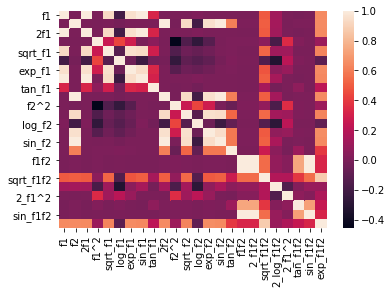

In [4]:
import seaborn as sns

sns.heatmap(data.corr());

## 3. Callbacks

In [33]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from datetime import datetime

''' AUC Ref "" https://stackoverflow.com/questions/41032551/
how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras'''

class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict_proba(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict_proba(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')

        tf.summary.scalar('train auc', data=round(roc_train,4), step=epoch)
        tf.summary.scalar('valid auc', data=round(roc_val,4), step=epoch)
        print("\n", "#"*200, "\n")

        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

roc = RocCallback(training_data=(X_train, Y_train),
                  validation_data=(X_test, Y_test))

In [34]:
from keras import backend as K

def micro_f1(y_true, y_pred):
  def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  #2*pi*row / (pi + row): micro-f1
  micro_f1 = (2*precision*recall)/(precision+recall+K.epsilon()) 
  return micro_f1

def get_model(act_fn, initializer, metrics=None):
  # Set the input shape
  input_shape = (X_train.shape[1],)
  print(f'Feature shape: {input_shape}')
  # Create the model
  model = Sequential()
  model.add(Dense(50, input_shape=input_shape, activation=act_fn, kernel_initializer=initializer))
  model.add(Dense(25, activation=act_fn))
  model.add(Dense(10, activation=act_fn))
  model.add(Dense(5, activation=act_fn))
  model.add(Dense(3, activation=act_fn))
  model.add(Dense(num_classes, activation='sigmoid'))
  sgd = SGD(lr=0.01, momentum=0.9)
  # Configure the model and start training
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[micro_f1], run_eagerly=True)

  return model

In [35]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.val_acc = dict()
        self.lr = dict() 
        self.val_loss = dict()

    def on_train_begin(self, logs=None):
        keys = list(logs.keys())

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        title="Learning Rate Schedule"
        epochs = list(self.lr.keys())
        lrs = list(self.lr.values())

        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs, color='green', marker='o', linestyle='dashed')
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
        plt.savefig("lrng_rate.png")
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        lr_flag = False
        print("\nEnd epoch {} of training; got log keys: {}".format(epoch, logs))

        try : 
          if logs['val_micro_f1']:
            self.val_acc[str(epoch)] = logs['val_micro_f1']
            val_loss = logs['val_loss']
            self.val_loss[epoch] = val_loss
          elif logs['AUC_custom']:
            self.val_acc[str(epoch)] = logs['val_AUC_custom']
            val_loss = logs['val_loss']
            self.val_loss[epoch] = val_loss

        except:
          pass

        if epoch>=1:
          #learning rate reduce if prev_val_acc > next_val_acc epoch drop 10%
          if self.val_acc[str(epoch-1)] > self.val_acc[str(epoch)]:
            lr_flag = True
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            scheduled_lr = lr * 0.90
            tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)

            print(f"\n custom learning rate by val_accracy if prev_val_acc > next_val_acc epoch drop 10% : {lr}\n")
            self.lr[str(epoch+1)]= lr

          #learning rate for every 3 epoch drop 5%
          elif ((epoch+1) % 3 == 0) and lr_flag==False:
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            schedule = float(lr * 0.95)
            tf.keras.backend.set_value(self.model.optimizer.lr, schedule)
            print(f"\n custom learning rate by every 3rd epoch {lr}\n")
            self.lr[str(epoch+1)]= lr
          
          #save model if prev_val_acc < next_val_acc BEST_MODEL = TRUE
          elif self.val_acc[str(epoch-1)] < self.val_acc[str(epoch)]:
            try:
              os.makedirs(("/content/best_model"))
            except:
              pass

            name = '/content/best_model/weights%08d.h5' % epoch

            # Record the best weights if current results is better.
            model = self.model.get_weights()
            print("\n", "#"*100, "\n", "Best Weights Saved : ", "\n", "#"*100)
            # model = load_model(model)
            self.model.save(name)

            # self.model.savefig("/content/best_model/best_model.png")
            with open("/content/best_model/best_weights.txt", "w+") as f:
              f.write(str(model))
          
          #if val loss is nan, stop_training
          elif val_loss != 'int' or val_loss != 'float':
            print("\n", "#"*100, "\n", "val loss is nan - Train Termination Execcuted: ", "\n", "#"*100)
            self.model.stop_training = True

          # early stopping if val_acc is not improved for last 2 epochs
          elif epoch >= 2:
            val_loss = type(logs['val_loss'])
            if round(self.val_acc[str(epoch-1)] - self.val_acc[str(epoch-2)], 4) == 0:
              print("\n", "#"*100, "\n", "Early Stopping Executed: ", "\n", "#"*100)
              self.model.stop_training = True

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("\nStop testing; got log keys: {}".format(logs))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())

## 4. Model

### Model 1

In [ ]:
from datetime import datetime
import os

logdir = "logs1/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_grads=True)

In [ ]:
%tensorboard --logdir logs1

Feature shape: (24,)
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.6822 - micro_f1: 0.5514
Stop testing; got log keys: {'loss': 0.6399805545806885, 'micro_f1': 0.531017541885376}
52/52 [==============================] - 5s 40ms/step - loss: 0.6819 - micro_f1: 0.5519 - val_loss: 0.6400 - val_micro_f1: 0.5310

End epoch 0 of training; got log keys: {'loss': 0.6662553548812866, 'micro_f1': 0.5798256397247314, 'val_loss': 0.6399805545806885, 'val_micro_f1': 0.531017541885376}
roc-auc_train: 0.7093 - roc-auc_val: 0.7167                                                                                                    

 ######################################################################################################################################################################################################## 

Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.6309 - micro_f1: 0.6386
Stop testing; got log keys: {'loss': 0.6120874285697937,

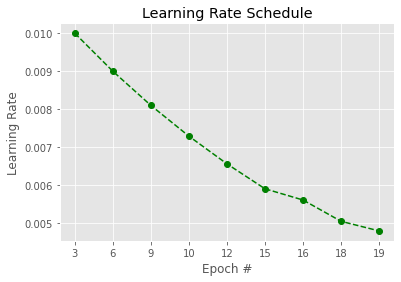

In [ ]:
model1 = get_model('tanh', 'RandomUniform')

history_tanh = model1.fit(X_train, Y_train.ravel(), epochs=20, batch_size=250, 
                          verbose=1, validation_split=0.2,
                          callbacks=[CustomCallback(), tensorboard_callback, roc])

# Test the model after training
test_results = model1.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - micro_f1: {test_results[1]}%')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

ypred = model1.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.67625 

              precision    recall  f1-score   support

           0       0.71      0.61      0.65      2000
           1       0.65      0.75      0.70      2000

    accuracy                           0.68      4000
   macro avg       0.68      0.68      0.67      4000
weighted avg       0.68      0.68      0.67      4000



### Model 2

In [ ]:
from datetime import datetime
import os

logdir = "logs2/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_grads=True)

%tensorboard --logdir logs2

Feature shape: (24,)
Epoch 1/20
50/52 [===========================>..] - ETA: 0s - loss: 0.6914 - micro_f1: 0.2337
Stop testing; got log keys: {'loss': 0.6886957287788391, 'micro_f1': 0.526188313961029}
52/52 [==============================] - 2s 33ms/step - loss: 0.6914 - micro_f1: 0.2379 - val_loss: 0.6887 - val_micro_f1: 0.5262

End epoch 0 of training; got log keys: {'loss': 0.6907801628112793, 'micro_f1': 0.30893611907958984, 'val_loss': 0.6886957287788391, 'val_micro_f1': 0.526188313961029}
roc-auc_train: 0.6873 - roc-auc_val: 0.6876                                                                                                    

 ######################################################################################################################################################################################################## 

Epoch 2/20
51/52 [============================>.] - ETA: 0s - loss: 0.6881 - micro_f1: 0.5939
Stop testing; got log keys: {'loss': 0.6826425790786743

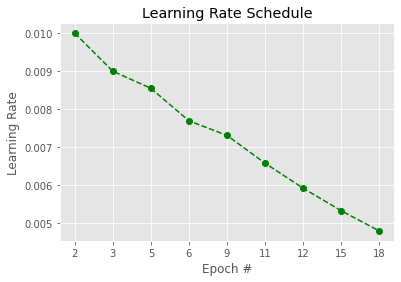

In [ ]:
model2 = get_model('relu', 'RandomUniform')

history_relu_1 = model2.fit(X_train, Y_train.ravel(), epochs=20, batch_size=250, 
                         verbose=1, validation_split=0.2, 
                         callbacks=[CustomCallback(), roc, tensorboard_callback_2])

# Test the model after training
test_results = model2.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - micro_f1: {test_results[1]}%')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

ypred = model2.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print("micro-f1 is ", test_results[1], "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.675 

micro-f1 is  0.6838955879211426 

              precision    recall  f1-score   support

           0       0.69      0.63      0.66      2000
           1       0.66      0.72      0.69      2000

    accuracy                           0.68      4000
   macro avg       0.68      0.68      0.67      4000
weighted avg       0.68      0.68      0.67      4000



### Model 3

In [ ]:
from datetime import datetime
import os

logdir = "logs3/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_grads=True)

%tensorboard --logdir logs3

Feature shape: (24,)
Epoch 1/20
50/52 [===========================>..] - ETA: 0s - loss: 0.7176 - micro_f1: 0.4156
Stop testing; got log keys: {'loss': 0.6772550344467163, 'micro_f1': 0.5948480367660522}
52/52 [==============================] - 2s 33ms/step - loss: 0.7164 - micro_f1: 0.4118 - val_loss: 0.6773 - val_micro_f1: 0.5948

End epoch 0 of training; got log keys: {'loss': 0.6961822509765625, 'micro_f1': 0.35076263546943665, 'val_loss': 0.6772550344467163, 'val_micro_f1': 0.5948480367660522}
roc-auc_train: 0.6083 - roc-auc_val: 0.6112                                                                                                    

 ######################################################################################################################################################################################################## 

Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.6761 - micro_f1: 0.6000
Stop testing; got log keys: {'loss': 0.65577912330627

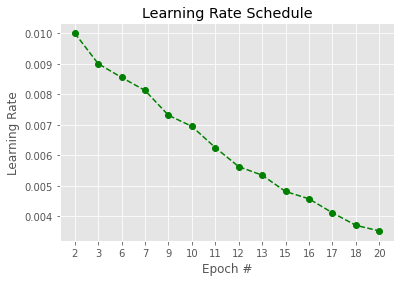

In [ ]:
model3 = get_model('relu', 'he_uniform')

history_relu_2 = model3.fit(X_train, Y_train.ravel(), epochs=20, batch_size=250, 
                         verbose=1, validation_split=0.2, 
                         callbacks=[CustomCallback(), roc, tensorboard_callback])

# Test the model after training
test_results = model3.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - micro_f1: {test_results[1]}%')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

ypred = model3.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print("micro -f1 is ", test_results[1], "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.6755 

micro -f1 is  0.6693171858787537 

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      2000
           1       0.68      0.67      0.67      2000

    accuracy                           0.68      4000
   macro avg       0.68      0.68      0.68      4000
weighted avg       0.68      0.68      0.68      4000



In [ ]:
!pip install shap

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

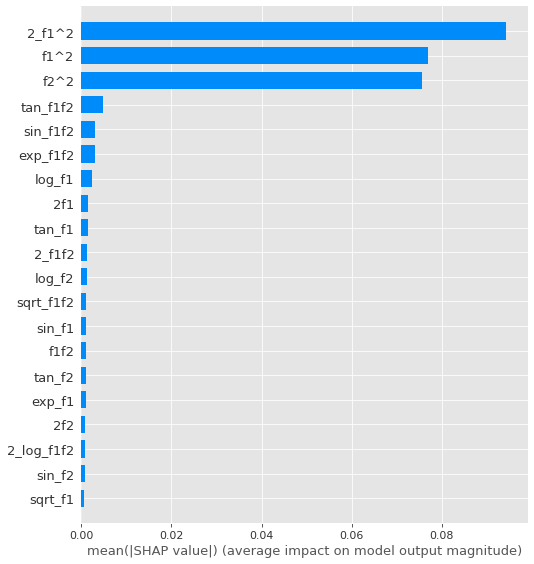

In [ ]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

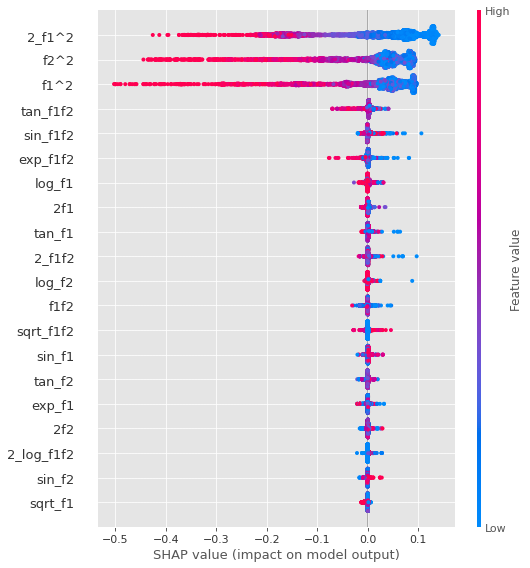

In [ ]:
import matplotlib.pyplot as plt

shap_values = shap.TreeExplainer(model).shap_values(X_test)

f = plt.figure()
shap.summary_plot(shap_values, X_test)
f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

# Model 4

In [ ]:
!pip install keras-tuner

In [38]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


def build_hypermodel(hp):

  input_shape = (X_train.shape[1],)

  model = Sequential()

  model.add(Dense(units=hp.Int(name='units_1',
            min_value=128, max_value=256, step=32), 
            input_shape=input_shape,
            activation = hp.Choice(name='a_1', 
                                   values=['relu','tanh','selu','swish'])))
  
  model.add(Dense(hp.Int('units_2', 32, 64, 16),
            activation = hp.Choice(name='a_2', 
                                   values=['relu','selu','swish'])))
  
  model.add(Dense(hp.Int('units_3', 16, 32, 8),
            activation = hp.Choice(name='a_3', 
                                   values=['relu','swish'])))
  
  model.add(Dense(hp.Int('units_4', 8, 16, 4),
            activation = hp.Choice(name='a_4',
                                   values=['relu','swish'])))
  
  model.add(Dense(hp.Int('units_5', 2, 4, 1),
            activation = hp.Choice(name='a_5', 
                                   values=['relu','swish'])))
  
  model.add(Dense(num_classes, activation='sigmoid'))

  sgd = SGD(lr=0.01, momentum=0.9)
  
  model.compile(loss='binary_crossentropy', optimizer=sgd, 
                metrics=['accuracy'], run_eagerly=True)
  
  return model

In [7]:
tuner = RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=3,
    directory='my_dir2',
    project_name='HyperModel')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}
a_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'swish'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': None}
a_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'swish'], 'ordered': False}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 8, 'sampling': None}
a_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'swish'], 'ordered': False}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 4, 'sampling': None}
a_4 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'swish'], 'ordered': False}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value':

In [10]:
tuner.search(X_train, Y_train, 
             steps_per_epoch=128,
             epochs=20,
             validation_data=(X_test, Y_test), callbacks=[stop_early])

Trial 50 Complete [00h 02m 20s]
val_accuracy: 0.6789166529973348

Best val_accuracy So Far: 0.6799166798591614
Total elapsed time: 01h 49m 47s
INFO:tensorflow:Oracle triggered exit


In [24]:
best_model = tuner.get_best_models(num_models=1)[0]

In [27]:
from sklearn.metrics import classification_report, accuracy_score

ypred = best_model.predict(X_test)

ypred = [1 if i>=0.5 else 0 for i in ypred.ravel()]

print("accuracy_score is ", accuracy_score(Y_test, ypred), "\n")

print(classification_report(Y_test, ypred))

accuracy_score is  0.68075 

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      2000
           1       0.68      0.67      0.68      2000

    accuracy                           0.68      4000
   macro avg       0.68      0.68      0.68      4000
weighted avg       0.68      0.68      0.68      4000



In [23]:
tuner.results_summary()

Results summary
Results in my_dir2/HyperModel
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_1: 128
a_1: relu
units_2: 32
a_2: selu
units_3: 24
a_3: swish
units_4: 16
a_4: swish
units_5: 2
a_5: swish
Score: 0.6799166798591614
Trial summary
Hyperparameters:
units_1: 160
a_1: swish
units_2: 64
a_2: relu
units_3: 32
a_3: swish
units_4: 12
a_4: relu
units_5: 3
a_5: relu
Score: 0.6796666582425436
Trial summary
Hyperparameters:
units_1: 256
a_1: relu
units_2: 32
a_2: swish
units_3: 16
a_3: relu
units_4: 12
a_4: swish
units_5: 4
a_5: relu
Score: 0.6795000036557516
Trial summary
Hyperparameters:
units_1: 224
a_1: tanh
units_2: 64
a_2: swish
units_3: 32
a_3: relu
units_4: 16
a_4: relu
units_5: 3
a_5: swish
Score: 0.6795000036557516
Trial summary
Hyperparameters:
units_1: 160
a_1: selu
units_2: 48
a_2: relu
units_3: 24
a_3: swish
units_4: 12
a_4: swish
units_5: 4
a_5: swish
Score: 0.6794166763623556
Trial summary
Hyperparameters:
units

In [ ]:
from datetime import datetime
import os

logdir = "logs4/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_grads=True)

%tensorboard --logdir logs4

In [44]:
def get_model():

  input_shape = (X_train.shape[1],)

  model = Sequential()

  model.add(Dense(128, 
            input_shape=input_shape,
            activation = 'relu'))
  
  model.add(Dense(32,
            activation = 'selu'))
  
  model.add(Dense(24,
            activation = 'swish'))
  
  model.add(Dense(16,
            activation = 'swish'))
  
  model.add(Dense(2,
            activation = 'swish'))
  
  model.add(Dense(num_classes, activation='sigmoid'))

  sgd = SGD(lr=0.01, momentum=0.9)
  
  model.compile(loss='binary_crossentropy', optimizer=sgd, 
                metrics=[micro_f1], run_eagerly=True)
  
  return model

Epoch 1/20
51/52 [============================>.] - ETA: 0s - loss: 0.6857 - micro_f1: 0.3659
Stop testing; got log keys: {'loss': 0.6591938734054565, 'micro_f1': 0.5882662534713745}
52/52 [==============================] - 1s 24ms/step - loss: 0.6855 - micro_f1: 0.3690 - val_loss: 0.6592 - val_micro_f1: 0.5883

End epoch 0 of training; got log keys: {'loss': 0.680046021938324, 'micro_f1': 0.4479726552963257, 'val_loss': 0.6591938734054565, 'val_micro_f1': 0.5882662534713745}
roc-auc_train: 0.6673 - roc-auc_val: 0.6728                                                                                                    

 ######################################################################################################################################################################################################## 

Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.6585 - micro_f1: 0.6135
Stop testing; got log keys: {'loss': 0.6286314129829407, 'micro_f1': 0.65684

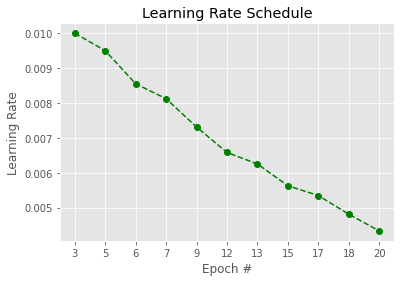

In [45]:
model4 = get_model()

history_relu_2 = model4.fit(X_train, Y_train.ravel(), epochs=20, batch_size=250, 
                         verbose=1, validation_split=0.2, 
                         callbacks=[CustomCallback(), roc, tensorboard_callback])

# Test the model after training
test_results = model4.evaluate(X_test, Y_test, verbose=1)

print(f'\nTest results - Loss: {test_results[0]} - micro_f1: {test_results[1]}%')

#Result

In [48]:
from prettytable import PrettyTable 

# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Model", "micro-F1", "AUC", 'Accuracy', 'Activation', 'Weight_Initializer']) 

# Add rows 
myTable.add_row(["1", "67 %", "74 %", "68 %", 'tanh', 'RandomUniform']) 
myTable.add_row(["2", "68 %", "74 %", "68 %", 'relu', 'RandomUniform']) 
myTable.add_row(["3", "67 %", "74 %", "68 %", 'relu', 'he_uniform']) 
myTable.add_row(["4", "68 %", "74 %", "68 %", 'relu + selu + swish' , 'glorot_uniform']) 

print(myTable)

+-------+----------+------+----------+---------------------+--------------------+
| Model | micro-F1 | AUC  | Accuracy |      Activation     | Weight_Initializer |
+-------+----------+------+----------+---------------------+--------------------+
|   1   |   67 %   | 74 % |   68 %   |         tanh        |   RandomUniform    |
|   2   |   68 %   | 74 % |   68 %   |         relu        |   RandomUniform    |
|   3   |   67 %   | 74 % |   68 %   |         relu        |     he_uniform     |
|   4   |   68 %   | 74 % |   68 %   | relu + selu + swish |   glorot_uniform   |
+-------+----------+------+----------+---------------------+--------------------+
